**3) Preprocese los datos:**
- Elimine valores atípicos si existen.
- Estandarice las variables independientes.
- Realice análisis de normalidad y multicolinealidad.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# Cargar Dataset
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Dividir datos
X = df.drop('target', axis=1)
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Análisis de normalidad
print("\nPruebas de normalidad (Shapiro-Wilk):")
for i, col in enumerate(X.columns):
    stat, p = stats.shapiro(X_train_scaled[:, i])
    print(f"{col}: p-value = {p:.4f}")

# Análisis de multicolinealidad
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif["Variable"] = X.columns
print("\nFactores de inflación de varianza (VIF):")
print(vif)


Pruebas de normalidad (Shapiro-Wilk):
sepal length (cm): p-value = 0.0351
sepal width (cm): p-value = 0.3257
petal length (cm): p-value = 0.0000
petal width (cm): p-value = 0.0000

Factores de inflación de varianza (VIF):
          VIF           Variable
0  263.825336  sepal length (cm)
1   94.136645   sepal width (cm)
2  184.961589  petal length (cm)
3   58.002559   petal width (cm)


**4) Implemente en Python los siguientes modelos:**
- Aplicación de PCA y reducción a 2 componentes principales.
- Visualización de la proyección de los datos en el nuevo espacio PCA.
- Aplicación de LDA y reducción a 2 componentes discriminantes.
- Visualización de la proyección de los datos en el nuevo espacio LDA.

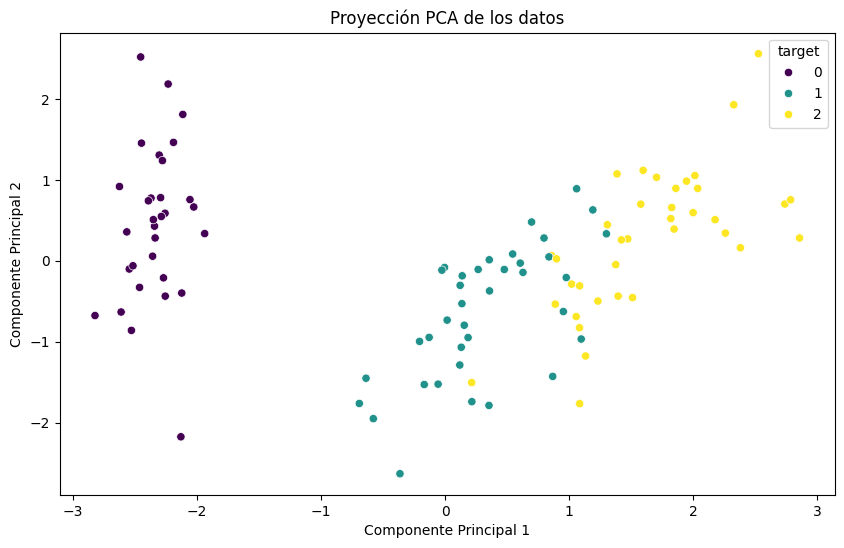

In [20]:
# Aplicación de PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_pca[:,0], y=X_train_pca[:,1], hue=y_train, palette='viridis')
plt.title('Proyección PCA de los datos')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

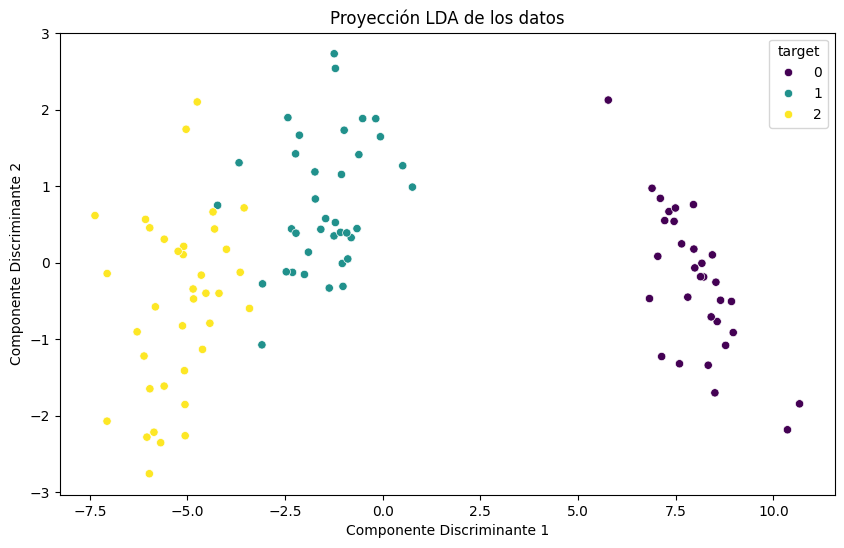

In [21]:
# Aplicación de LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_lda[:,0], y=X_train_lda[:,1], hue=y_train, palette='viridis')
plt.title('Proyección LDA de los datos')
plt.xlabel('Componente Discriminante 1')
plt.ylabel('Componente Discriminante 2')
plt.show()

**5) Entrene un modelo de regresión logística en el espacio proyectado por PCA y LDA. Compare el rendimiento del modelo en ambos casos mediante:**
- Precisión,
- Matriz de confusión,
- Curva ROC,
- Curva de aprendizaje.

In [22]:
# Modelos de regresión logistica
# PCA
lr_pca = LogisticRegression(max_iter=200)
lr_pca.fit(X_train_pca, y_train)
y_pred_pca = lr_pca.predict(X_test_pca)

# LDA
lr_lda = LogisticRegression(max_iter=200)
lr_lda.fit(X_train_lda, y_train)
y_pred_lda = lr_lda.predict(X_test_lda)

In [23]:
# Evaluacin
# Precisión
print(f"\nPrecisión PCA: {accuracy_score(y_test, y_pred_pca):.4f}")
print(f"Precisión LDA: {accuracy_score(y_test, y_pred_lda):.4f}")


Precisión PCA: 0.9111
Precisión LDA: 1.0000


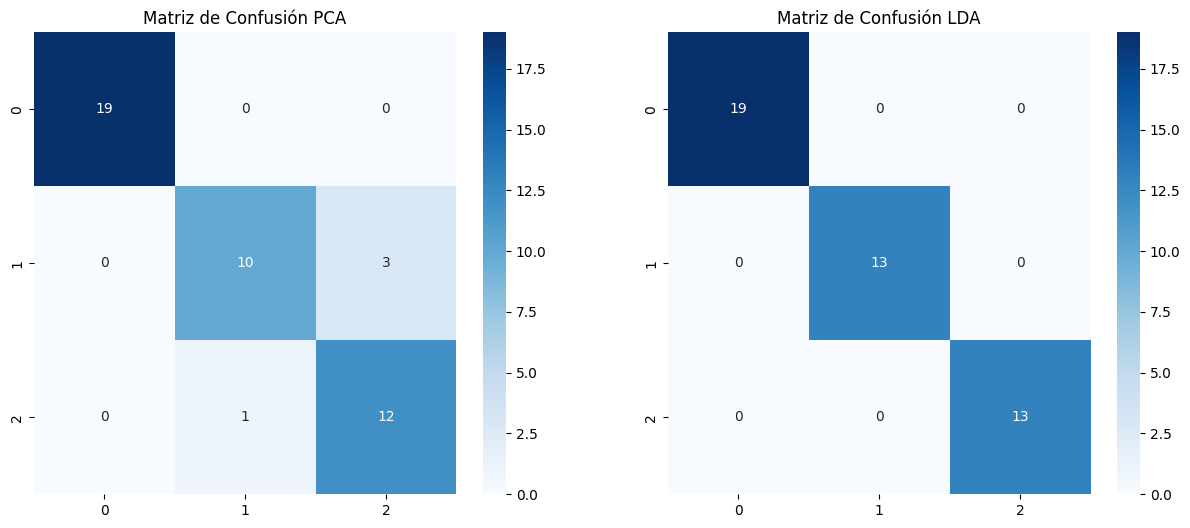

In [24]:
# Matrices de confusión
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
conf_matrix_pca = confusion_matrix(y_test, y_pred_pca)
conf_matrix_lda = confusion_matrix(y_test, y_pred_lda)

sns.heatmap(conf_matrix_pca, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Matriz de Confusión PCA')
sns.heatmap(conf_matrix_lda, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Matriz de Confusión LDA')
plt.show()

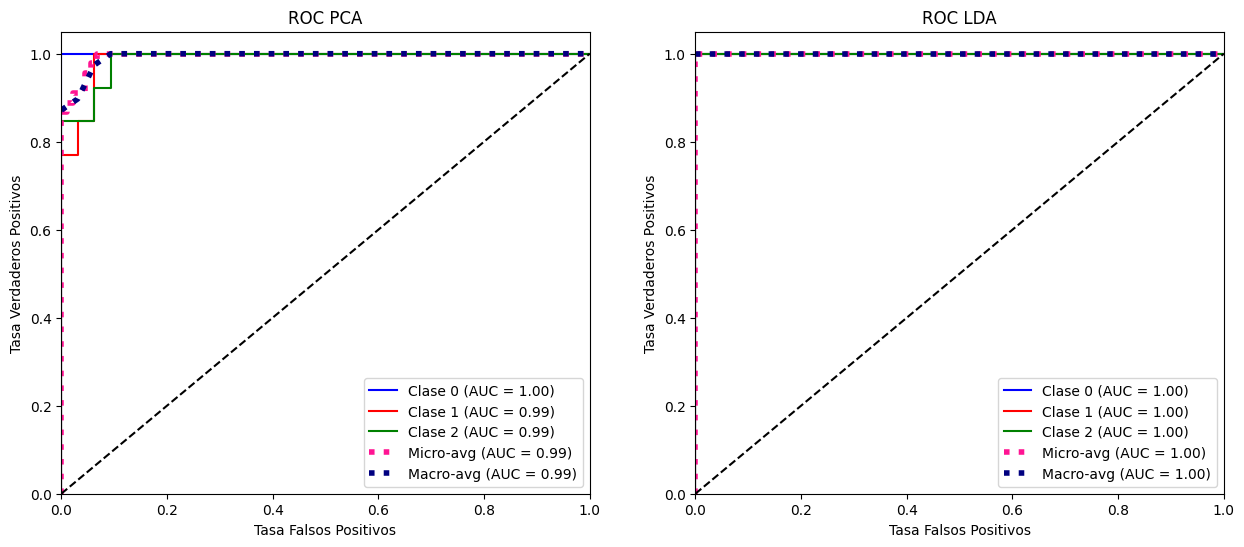

In [25]:
# Curvas ROC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

def plot_multiclass_roc(clf, X_test, y_test, n_classes, ax, title):
    y_score = clf.predict_proba(X_test)
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    
    fpr, tpr = dict(), dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Micro-average
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    colors = ['blue', 'red', 'green']
    for i, color in zip(range(n_classes), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=1.5,
                label=f'Clase {i} (AUC = {roc_auc[i]:.2f})')
    
    ax.plot(fpr["micro"], tpr["micro"],
            label=f'Micro-avg (AUC = {roc_auc["micro"]:.2f})',
            color='deeppink', linestyle=':', linewidth=4)
    
    ax.plot(fpr["macro"], tpr["macro"],
            label=f'Macro-avg (AUC = {roc_auc["macro"]:.2f})',
            color='navy', linestyle=':', linewidth=4)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title(title)
    ax.set_xlabel('Tasa Falsos Positivos')
    ax.set_ylabel('Tasa Verdaderos Positivos')
    ax.legend(loc="lower right")

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_multiclass_roc(lr_pca, X_test_pca, y_test, n_classes=3, ax=ax[0], title='ROC PCA')
plot_multiclass_roc(lr_lda, X_test_lda, y_test, n_classes=3, ax=ax[1], title='ROC LDA')
plt.show()

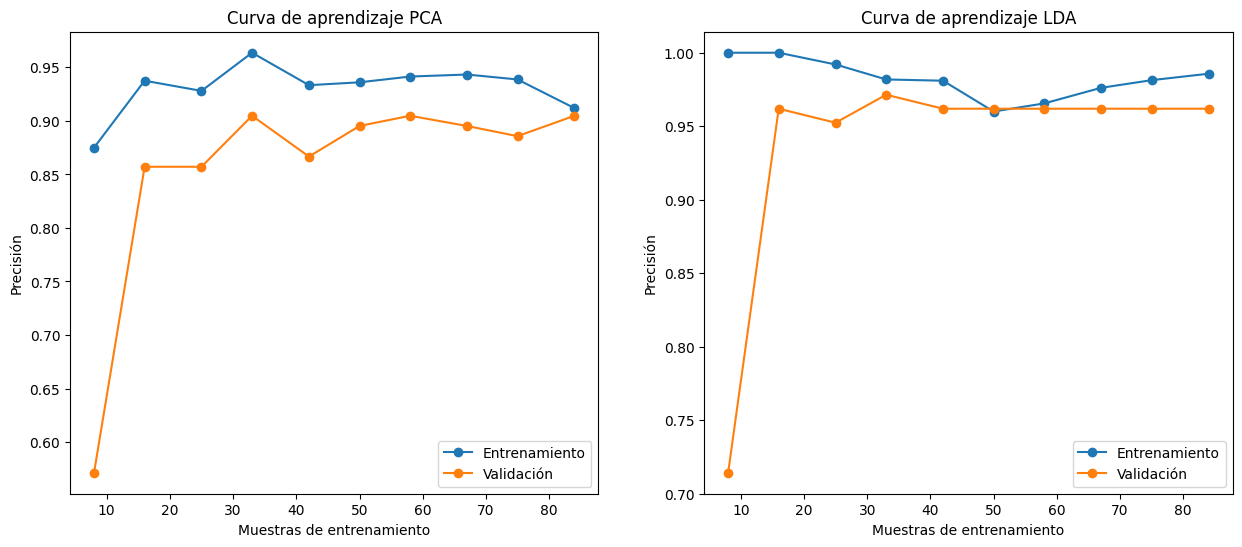

In [26]:
# Curvas de aprendizaje
def plot_learning_curve(estimator, title, X, y, ax):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))
    
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Entrenamiento")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Validación")
    ax.set_title(title)
    ax.set_xlabel("Muestras de entrenamiento")
    ax.set_ylabel("Precisión")
    ax.legend()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
plot_learning_curve(lr_pca, "Curva de aprendizaje PCA", X_train_pca, y_train, ax[0])
plot_learning_curve(lr_lda, "Curva de aprendizaje LDA", X_train_lda, y_train, ax[1])
plt.show()

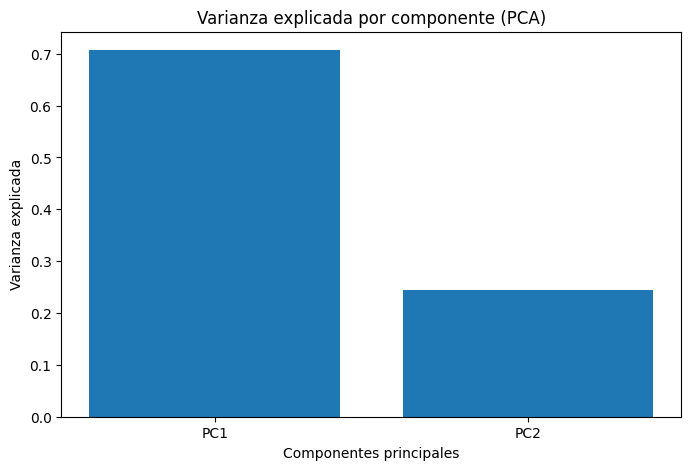

In [27]:
# Varianza explicada PCA
plt.figure(figsize=(8, 5))
plt.bar(range(2), pca.explained_variance_ratio_)
plt.title('Varianza explicada por componente (PCA)')
plt.xlabel('Componentes principales')
plt.ylabel('Varianza explicada')
plt.xticks([0, 1], ['PC1', 'PC2'])
plt.show()